In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 

In [2]:
# Device Characteristics =================================
#full light
gamma_rf, gamma_gf, gamma_bf = 2.4767, 2.4286, 2.3792
M_f = np.array([[95.57,  64.67,  33.01],
                [49.49, 137.29,  14.76],
                [ 0.44,  27.21, 169.83]])

#low light
gamma_rl, gamma_gl, gamma_bl = 2.2212, 2.1044, 2.1835
M_l = np.array([[4.61, 3.35, 1.78],
                [2.48, 7.16, 0.79],
                [0.28, 1.93, 8.93]])
#=========================================================

In [3]:
def device_rgb_to_xyz(image, M, gamma_r, gamma_g, gamma_b) -> np.ndarray:
    """
    Transforms an RGB image using the formula [x y z] = M [R^gamma_r G^gamma_g B^gamma_b].
    
    Args:
        image (numpy.ndarray): Input image as a 3D numpy array (H x W x 3) in RGB format.

        M (numpy.ndarray): 3x3 transformation matrix. (device characteristic)

        gamma_r (float): Gamma correction for the red channel. (device characteristic)

        gamma_g (float): Gamma correction for the green channel. (device characteristic)

        gamma_b (float): Gamma correction for the blue channel. (device characteristic)

    Returns:
        numpy.ndarray: Transformed image (H x W x 3).
    """
    # Apply gamma correction to each channel
    image_gamma = np.zeros_like(image, dtype=np.float32)
    h ,w, _ = image.shape

    # Assert all values are in the range [0, 255]
    assert np.all(image >= 0), "Some values are less than 0!"
    assert np.all(image <= 255), "Some values are greater than 255!"

    image_gamma[..., 0] = image[..., 0] ** gamma_r  # R^gamma_r
    image_gamma[..., 1] = image[..., 1] ** gamma_g  # G^gamma_g
    image_gamma[..., 2] = image[..., 2] ** gamma_b  # B^gamma_b

    # Apply the matrix transformation
    transformed = np.dot(M, image_gamma.reshape(-1, 3).T).T

    # Reshape back to the original image dimensions
    return transformed.reshape(h, w, 3)

In [ ]:
# Read the image 
image_bgr = cv2.imread("./Lenna.png")

# Convert the image from BGR to RGB if it exists. 
if image_bgr is not None:
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)  
else:
    raise FileNotFoundError("Image does not exist.") 

# Display the image dimensions
print("Image shape (H, W, C):", image_rgb.shape)

Image shape (H, W, C): (512, 512, 3)


In [8]:
image_xyz = device_rgb_to_xyz(
    image=image_rgb,
    M=M_f, 
    gamma_r=gamma_rf,
    gamma_g=gamma_gf,
    gamma_b=gamma_bf)

In [4]:
def ciecam02(image_xyz: np.ndarray, adapting_luminance: float, background_luminance: float) -> np.ndarray:
    """
    Converts an XYZ image to simplified CIECAM02 attributes (lightness, chroma, hue).
    
    Args:
        image_xyz (np.ndarray): Input image in XYZ color space (H x W x 3).
        adapting_luminance (float): Luminance of the adapting field.
        background_luminance (float): Luminance of the background field.
    
    Returns:
        np.ndarray: Image with CIECAM02 attributes (lightness J, chroma C, hue h).
    """
    # Constants for the CIECAM02 model
    F = 1.0  # Surround factor for 'average'
    n = background_luminance / adapting_luminance
    N_bb = N_cb = 0.725 * (1 / n) ** 0.2
    
    # Conversion from XYZ to LMS (Long, Medium, Short cones)
    M_CAT02 = np.array([[0.7328, 0.4296, -0.1624],
                        [-0.7036, 1.6975, 0.0061],
                        [0.0030, 0.0136, 0.9834]])
    
    h, w, _ = image_xyz.shape
    image_lms = np.dot(image_xyz.reshape(-1, 3), M_CAT02.T).reshape(h, w, 3)

    # Calculate the adapted cone responses
    D = F * (1 - (1/3.6) * np.exp((-adapting_luminance - 42)/92))  # Discounting factor
    LMS_a = D * image_lms + (1 - D) * image_lms.mean(axis=(0, 1))  # Adaptation

    # Calculate lightness, chroma, and hue
    A = (2 * LMS_a[..., 0] + LMS_a[..., 1] + (1/20) * LMS_a[..., 2]) * N_bb
    J = 100 * (A / adapting_luminance) ** 0.5
    C = 100 * (np.abs(LMS_a[..., 0] - LMS_a[..., 2]) / adapting_luminance)
    h = np.degrees(np.arctan2(LMS_a[..., 1], LMS_a[..., 0]))

    # Stack the results in an array
    ciecam02_attributes = np.stack((J, C, h), axis=-1)
    return ciecam02_attributes

In [9]:
# Convert the image to perceptual attributes 
ciecam02_JCh = ciecam02(
    image_xyz=image_xyz,
    adapting_luminance=63,
    background_luminance=25)

In [10]:
def inv_ciecam02(ciecam02_attributes: np.ndarray, adapting_luminance: float, background_luminance: float) -> np.ndarray:
    """
    Converts simplified CIECAM02 attributes (lightness, chroma, hue) back to the XYZ color space.
    
    Args:
        ciecam02_attributes (np.ndarray): CIECAM02 attributes (H x W x 3).
        adapting_luminance (float): Luminance of the adapting field.
        background_luminance (float): Luminance of the background field.
    
    Returns:
        np.ndarray: Reconstructed image in the XYZ color space.
    """
    # Constants
    F = 1.0  # Average surround
    n = background_luminance / adapting_luminance
    N_bb = N_cb = 0.725 * (1 / n) ** 0.2
    
    # Extract lightness (J), chroma (C), and hue (h)
    J, C, h = ciecam02_attributes[..., 0], ciecam02_attributes[..., 1], ciecam02_attributes[..., 2]
    
    # Calculate achromatic response A from lightness J
    A = (J / 100) ** 2 * adapting_luminance
    
    # Calculate adapted LMS values
    LMS_a = np.zeros_like(ciecam02_attributes)
    LMS_a[..., 0] = (A / (2 * N_bb))
    LMS_a[..., 1] = C * np.sin(np.radians(h))
    LMS_a[..., 2] = C * np.cos(np.radians(h))
    
    # Convert LMS back to XYZ
    M_CAT02_inv = np.linalg.inv(
        np.array([
            [0.7328, 0.4296, -0.1624],
            [-0.7036, 1.6975, 0.0061],
            [0.0030, 0.0136, 0.9834]]))
    
    image_xyz = np.dot(
        LMS_a.reshape(-1, 3), M_CAT02_inv.T).reshape(ciecam02_attributes.shape)
    return np.clip(image_xyz, 0, 1)  # Clipping for valid range


In [11]:
reconstructed_image_xyz = inv_ciecam02(
    ciecam02_attributes=ciecam02_JCh,
    adapting_luminance=63, 
    background_luminance=25)

### Unit Test for CAM 

In [12]:
def create_test_image(height: int = 100, width: int = 300) -> np.ndarray:
    """
    Creates a test image with color gradients and patches for testing.

    Args:
        height (int): Height of the test image.
        width (int): Width of the test image.

    Returns:
        np.ndarray: Generated test image in RGB format.
    """
    test_image = np.zeros((height, width, 3), dtype=np.uint8)

    # Divide the image into three vertical sections
    section_width = width // 3

    # Red gradient
    for i in range(section_width):
        test_image[:, i] = [255 * (i / section_width), 0, 0]

    # Green gradient
    for i in range(section_width):
        test_image[:, section_width + i] = [0, 255 * (i / section_width), 0]

    # Blue gradient
    for i in range(section_width):
        test_image[:, 2 * section_width + i] = [0, 0, 255 * (i / section_width)]

    return test_image

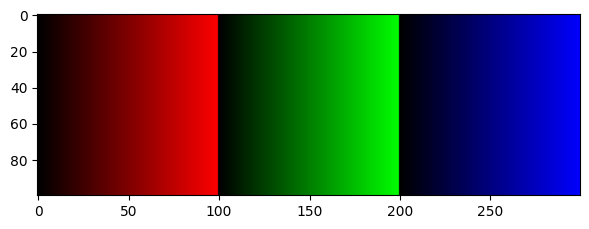

In [ ]:
test_image_rgb = create_test_image() 
plt.figure(figsize=(7, 7)) 
plt.imshow(test_image_rgb)
plt.show()

In [16]:
def test_ciecam02_transformations():
    """
    Tests the XYZ to CIECAM02 and inverse transformations.
    """
    # Create a test image
    test_img_rgb = create_test_image()
    
    # Convert to float and scale to [0, 1]
    test_img_rgb_float = test_img_rgb.astype(np.float32) / 255.0
    
    # Simulate device RGB to XYZ conversion (using a standard matrix for testing)
    D65_WHITE = np.array([
        [0.4124564, 0.3575761, 0.1804375],
        [0.2126729, 0.7151522, 0.0721750],
        [0.0193339, 0.1191920, 0.9503041]])
    test_img_xyz = np.dot(test_img_rgb_float.reshape(-1, 3), D65_WHITE.T).reshape(test_img_rgb.shape)
    
    # Define luminance parameters for a dim surround
    adapting_luminance = 20.0
    background_luminance = 4.0
    
    # Apply the forward transformation
    ciecam_attributes = ciecam02(test_img_xyz, adapting_luminance, background_luminance)
    
    # Ensure attributes are within valid ranges
    assert np.all(ciecam_attributes >= 0), "CIECAM02 attributes contain negative values!"
    
    # Apply the inverse transformation
    reconstructed_xyz = inv_ciecam02(ciecam_attributes, adapting_luminance, background_luminance)
    
    # Ensure values are within valid ranges
    assert np.all(reconstructed_xyz >= 0), "Reconstructed XYZ contains negative values!"
    
    # Compare the reconstructed XYZ to the original
    diff = np.abs(reconstructed_xyz - test_img_xyz)
    assert np.mean(diff) < 0.005, "Reconstructed XYZ differs significantly from the original!"
    
    print("CIECAM02 transformations passed all tests!")
